In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as pt
import torch.nn as nn
import torch.nn.functional as F


device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


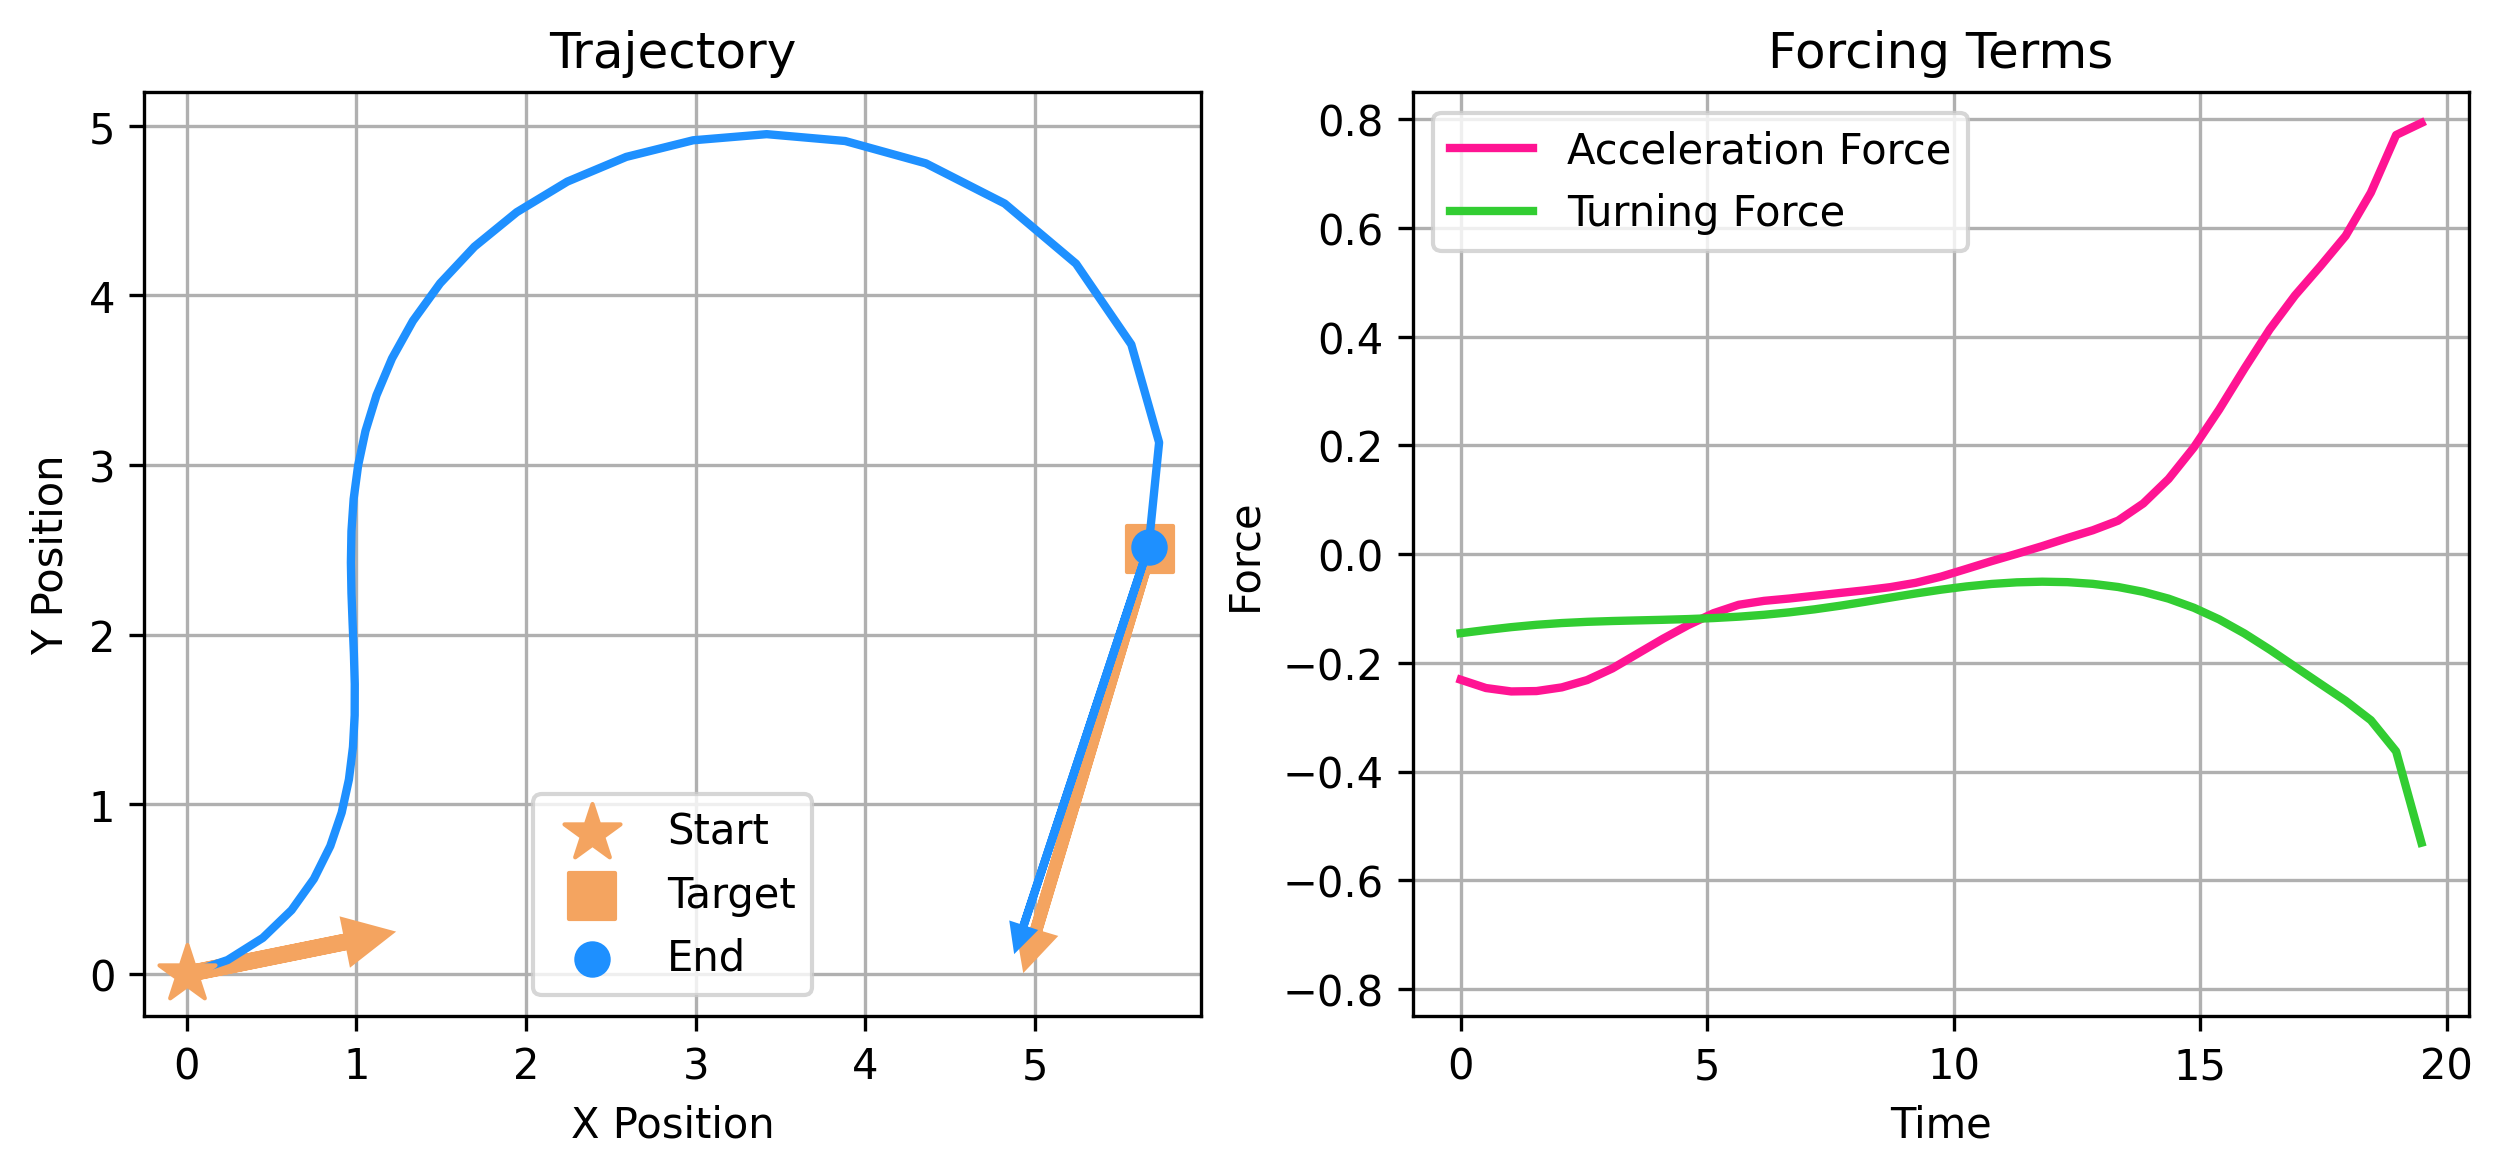

(<Figure size 3000x1200 with 2 Axes>,
 (<Axes: title={'center': 'Trajectory'}, xlabel='X Position', ylabel='Y Position'>,
  <Axes: title={'center': 'Forcing Terms'}, xlabel='Time', ylabel='Force'>))

In [128]:
def showTraj(V_mat, F_mat, ts, target, figaxs=None, show=True, alpha=0.5):
    if figaxs is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
    else:
        fig, (ax1, ax2) = figaxs

    VS = V_mat.detach().cpu().numpy() if isinstance(V_mat, pt.Tensor) else np.stack([_.detach() for _ in V_mat])
    FS = F_mat.detach().cpu().numpy()

    # lw = 2 if alpha == 1 else 0.75+alpha
    lw = 2 if alpha == 1 else 1.5

    ax1.plot(VS[:,0], VS[:,1], lw=lw, zorder=6, color='dodgerblue', alpha=alpha)

    ax2.plot(ts[:-1], FS[:,0], 'deeppink', lw=lw, alpha=alpha, label='Acceleration Force' if show else None)
    ax2.plot(ts[:-1], FS[:,1], 'limegreen', lw=lw, alpha=alpha, label='Turning Force' if show else None)


    if show:
        ax1.scatter(VS[0,0], VS[0,1], marker='*', color='sandybrown', s=200, zorder=6, label='Start')
        ax1.scatter(target[0], target[1], marker='s', color='sandybrown', s=120, label='Target')
        ax1.scatter(VS[-1,0], VS[-1,1], marker='o', color='dodgerblue', s=60, zorder=10, label='End')

        arrowDir = lambda V: (V[3]*np.cos(V[2]), V[3]*np.sin(V[2]))

        ax1.arrow(*VS[-1,0:2], *arrowDir(VS[-1]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=2, zorder=3)
        ax1.arrow(*target[0:2], *arrowDir(target.numpy()), color='sandybrown', head_width=0.15, head_length=0.15, lw=3, zorder=2)
        ax1.arrow(*VS[0,0:2], *arrowDir(VS[0]), color='sandybrown', head_width=0.15, head_length=0.15, lw=4, zorder=2)
        # ax1.arrow(*VS[0,0:2], *arrowDir(VS[0]), color='dodgerblue', head_width=0.1, head_length=0.1, lw=2, zorder=3)

        ax1.set_title('Trajectory')
        ax1.set_xlabel('X Position')
        ax1.set_ylabel('Y Position')
        ax1.axis('equal')
        ax1.grid()
        ax1.legend()

        ax2.legend()
        ax2.set_title('Forcing Terms')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Force')
        ax2.set_ylim([-0.85, 0.85])
        ax2.grid()
        plt.show()

    return fig, (ax1, ax2)
    

showTraj(V_mat, F_mat, ts, target, figaxs=None, show=True, alpha=1.0)

Equations of motion modified to work with autograd tree

In [3]:
def v_prime_components_autograd(v, dt):
    dt2 = dt*dt/2

    x = v[0]    # x coordinate
    y = v[1]    # y coordinate
    a = v[2]    # angle
    s = v[3]    # speed
    w = v[4]    # angular speed
    _0 = pt.zeros_like(x)
    _1 = pt.ones_like(x)

    A1 = pt.stack([x, y, a, s, w])
    A2 = pt.stack([s*pt.cos(a), s*pt.sin(a), w, _0, _0])
    A3 = pt.stack([-s*w*pt.sin(a), s*w*pt.cos(a), _0, _0, _0])
    A = A1 + dt*A2 + dt2*A3

    B2 = pt.stack([_0, _0, _0, _1, _0])
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0])
    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1])
    C3 = pt.stack([_0, _0, _1, _0, _0])
    C = dt*C2 + dt2*C3
    return A, B, C

def compute_path_autograd(v0, F_mat, t, target):
    V_mat = [v0]

    for i in range(len(t)-1):
        A, B, C = v_prime_components_autograd(V_mat[i], t[i+1] - t[i])
        V_mat.append(
            A + F_mat[i,0]*B + F_mat[i,1]*C
        )

    loss = 1/5 * pt.sum((V_mat[-1] - target)**2)
    return V_mat, loss

Using autograd while computing trajectory

Iteration 25, Loss: 2.6918113231658936
Iteration 50, Loss: 0.2890350818634033
Iteration 75, Loss: 0.06793513149023056
Iteration 100, Loss: 0.019441768527030945
Iteration 125, Loss: 0.01328826230019331
Iteration 150, Loss: 0.010671260766685009
Iteration 175, Loss: 0.009078647010028362
Iteration 200, Loss: 0.00781275425106287
Iteration 225, Loss: 0.006840901914983988
Iteration 250, Loss: 0.006071938201785088
Iteration 275, Loss: 0.005458621308207512
Iteration 300, Loss: 0.004961221944540739
Iteration 325, Loss: 0.004551161080598831
Iteration 350, Loss: 0.004207214340567589
Iteration 375, Loss: 0.003913677763193846
Iteration 400, Loss: 0.0036597836297005415
Iteration 425, Loss: 0.0034370676148682833
Iteration 450, Loss: 0.003239282639697194
Iteration 475, Loss: 0.0030622947961091995
Iteration 500, Loss: 0.002902563428506255
Iteration 525, Loss: 0.0028011524118483067
Iteration 550, Loss: 0.0027368031442165375
Iteration 575, Loss: 0.0026571201160550117
Iteration 600, Loss: 0.002569011412560

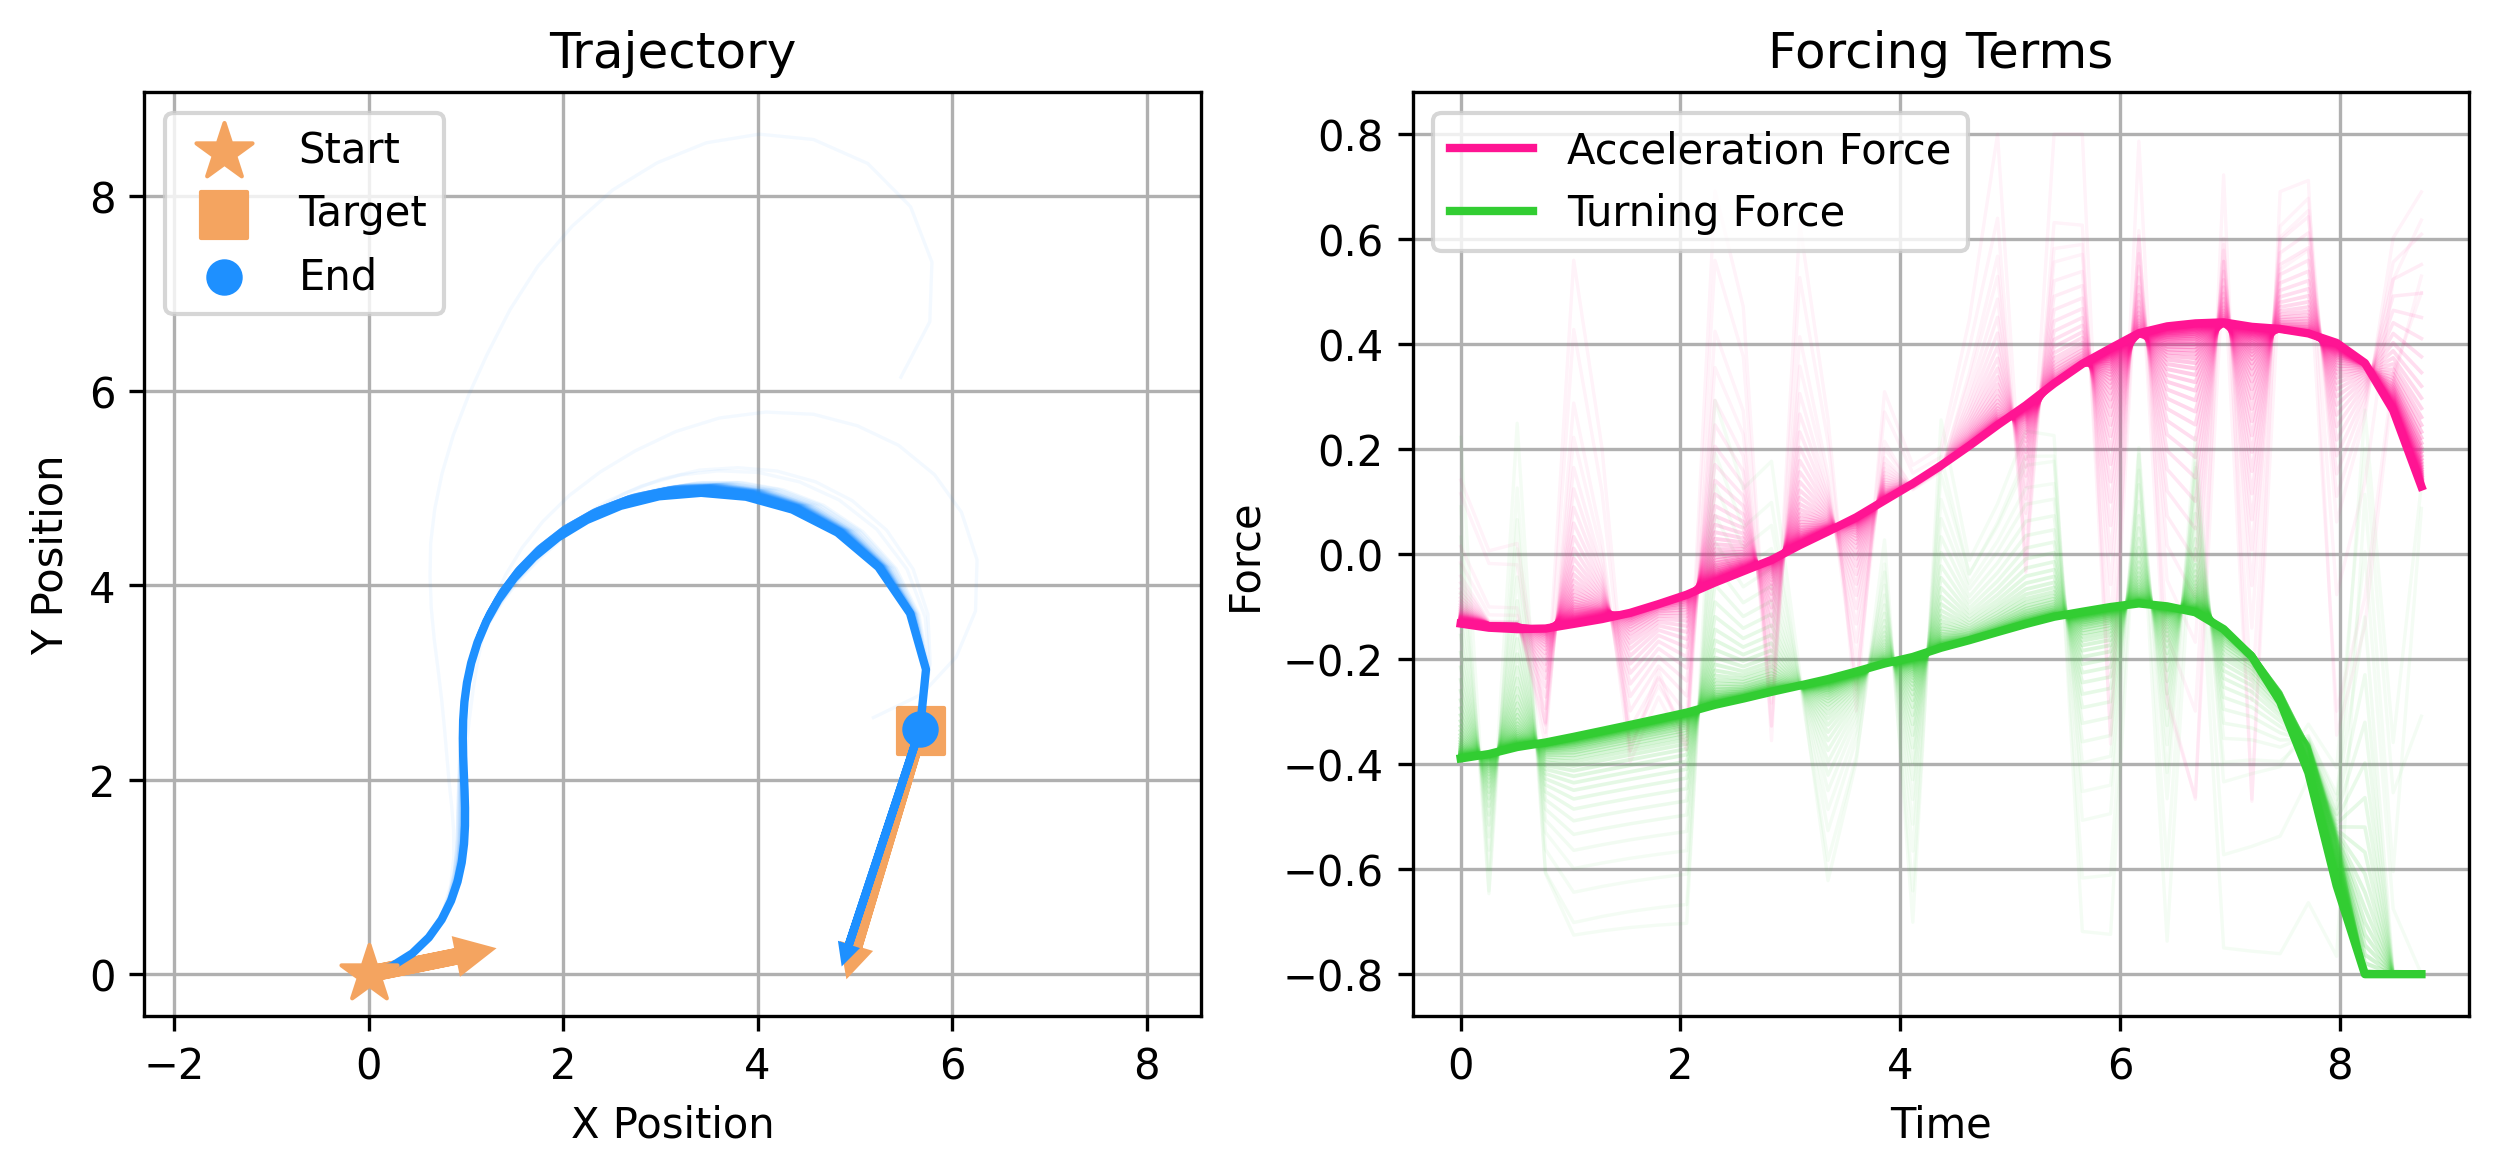

(<Figure size 3000x1200 with 2 Axes>,
 (<Axes: title={'center': 'Trajectory'}, xlabel='X Position', ylabel='Y Position'>,
  <Axes: title={'center': 'Forcing Terms'}, xlabel='Time', ylabel='Force'>))

In [103]:
v0 = pt.tensor([0, 0, 0.2, 1, 1])
target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75])
t0 = 0
t1 = 9       # designed for 5.5
dt_max = 0.25
n_ts = int((t1 - t0) / dt_max)
ts = pt.linspace(t0, t1, n_ts)

F_mat = pt.nn.Parameter(pt.randn((n_ts-1, 2)))
V_mat = compute_path_autograd(v0, F_mat, ts, target)
optim = pt.optim.AdamW([F_mat], lr=6e-2, weight_decay=1e-1)

figaxs = None

nsteps = 1000
for i in range(nsteps):
    optim.zero_grad()
    V_mat, loss = compute_path_autograd(v0, F_mat, ts, target)
    loss.backward()
    optim.step()
    with pt.no_grad():
        F_mat.clamp_(min=-0.8, max=0.8)

    if i % 25 == 24:
        print(f"Iteration {i+1}, Loss: {loss.item()}")
        if i < nsteps-1:
            figaxs = showTraj(V_mat, F_mat, ts, target, figaxs=figaxs, show=False, alpha=0.5*max(0.1, i/nsteps))

showTraj(V_mat, F_mat, ts, target, figaxs=figaxs, show=True, alpha=1.0)

Use analitical equations to speed up gradient computation

In [104]:
def v_prime_components(v, dt):
    dt2 = dt*dt/2

    x = v[0]    # x coordinate
    y = v[1]    # y coordinate
    a = v[2]    # angle
    s = v[3]    # speed
    w = v[4]    # angular speed
    _0 = pt.zeros_like(x, device=device)
    _1 = pt.ones_like(x, device=device)

    A1 = pt.stack([x, y, a, s, w])
    A2 = pt.stack([s*pt.cos(a), s*pt.sin(a), w, _0, _0])
    A3 = pt.stack([-s*w*pt.sin(a), s*w*pt.cos(a), _0, _0, _0])
    A = A1 + dt*A2 + dt2*A3

    B2 = pt.stack([_0, _0, _0, _1, _0])
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0])
    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1])
    C3 = pt.stack([_0, _0, _1, _0, _0])
    C = dt*C2 + dt2*C3
    return A, B, C

def jacobian_components(v, dt):
    dt2 = dt*dt/2

    a = v[2]    # angle
    s = v[3]    # speed
    w = v[4]    # angular speed

    J_A1 = pt.eye(5, device=device)
    J_A2 = pt.tensor(
       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [-s*pt.sin(a), s*pt.cos(a), 0, 0, 0],
        [pt.cos(a), pt.sin(a), 0, 0, 0],
        [0, 0, 1, 0, 0]], device=device
    ).T
    J_A3 = pt.tensor(
       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [-s*w*pt.cos(a), -s*w*pt.sin(a), 0, 0, 0],
        [-w*pt.sin(a), w*pt.cos(a), 0, 0, 0],
        [-s*pt.sin(a), s*pt.cos(a), 0, 0, 0]], device=device
    ).T
    
    J_A = J_A1 + dt*J_A2 + dt2*J_A3

    J_B3 = pt.tensor(
       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [-pt.sin(a), pt.cos(a), 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], device=device
    ).T
    J_B = dt2*J_B3

    return J_A, J_B

def grad_v_plus_1(V_mat, ts):
    a = V_mat[:,2]

    _0 = pt.zeros_like(a)
    _1 = pt.ones_like(a)
    dt = (ts[1:] - ts[:-1])[:,pt.newaxis]
    dt2 = dt*dt/2

    B2 = pt.stack([_0, _0, _0, _1, _0], axis=1)
    B3 = pt.stack([pt.cos(a), pt.sin(a), _0, _0, _0], axis=1)

    B = dt*B2 + dt2*B3

    C2 = pt.stack([_0, _0, _0, _0, _1], axis=1)
    C3 = pt.stack([_0, _0, _1, _0, _0], axis=1)
    C = dt*C2 + dt2*C3

    grad = pt.stack([B, C], axis=1)
    return grad

def compute_path_gradient(v0, F_mat, ts, target):
    V_mat = pt.zeros((len(ts), 5), device=device)
    V_mat[0,:] = v0

    for i in range(len(ts)-1):
        A, B, C = v_prime_components(V_mat[i], ts[i+1] - ts[i])
        V_mat[i+1] = A + F_mat[i,0]*B + F_mat[i,1]*C

    loss = 1/5 * pt.sum((V_mat[-1] - target)**2)

    jacobians = pt.zeros((len(ts), 5, 5), device=device)

    jacobians[-1] = pt.eye(5)
    for i in range(len(ts)-2, -1, -1):
        J_A, J_B = jacobian_components(V_mat[i], ts[i+1] - ts[i])
        J = J_A + F_mat[i,0]*J_B
        jacobians[i] = jacobians[i+1] @ J

    # compute gradient from jacs
    YT = ((2/5) * (V_mat[-1] - target))
    V1_grad = grad_v_plus_1(V_mat[:-1,:], ts)

    grad = pt.einsum('nij,nmj->nmi', jacobians[1:], V1_grad)
    grad = pt.einsum('j,nij->ni', YT, grad)

    return V_mat, grad, loss


Iteration 50, Loss: 1.6028341054916382
Iteration 100, Loss: 0.7530103921890259
Iteration 150, Loss: 0.3796274960041046
Iteration 200, Loss: 0.19498734176158905
Iteration 250, Loss: 0.11608730256557465
Iteration 300, Loss: 0.08227762579917908
Iteration 350, Loss: 0.0685238465666771
Iteration 400, Loss: 0.061937812715768814
Iteration 450, Loss: 0.057440631091594696
Iteration 500, Loss: 0.05365676432847977


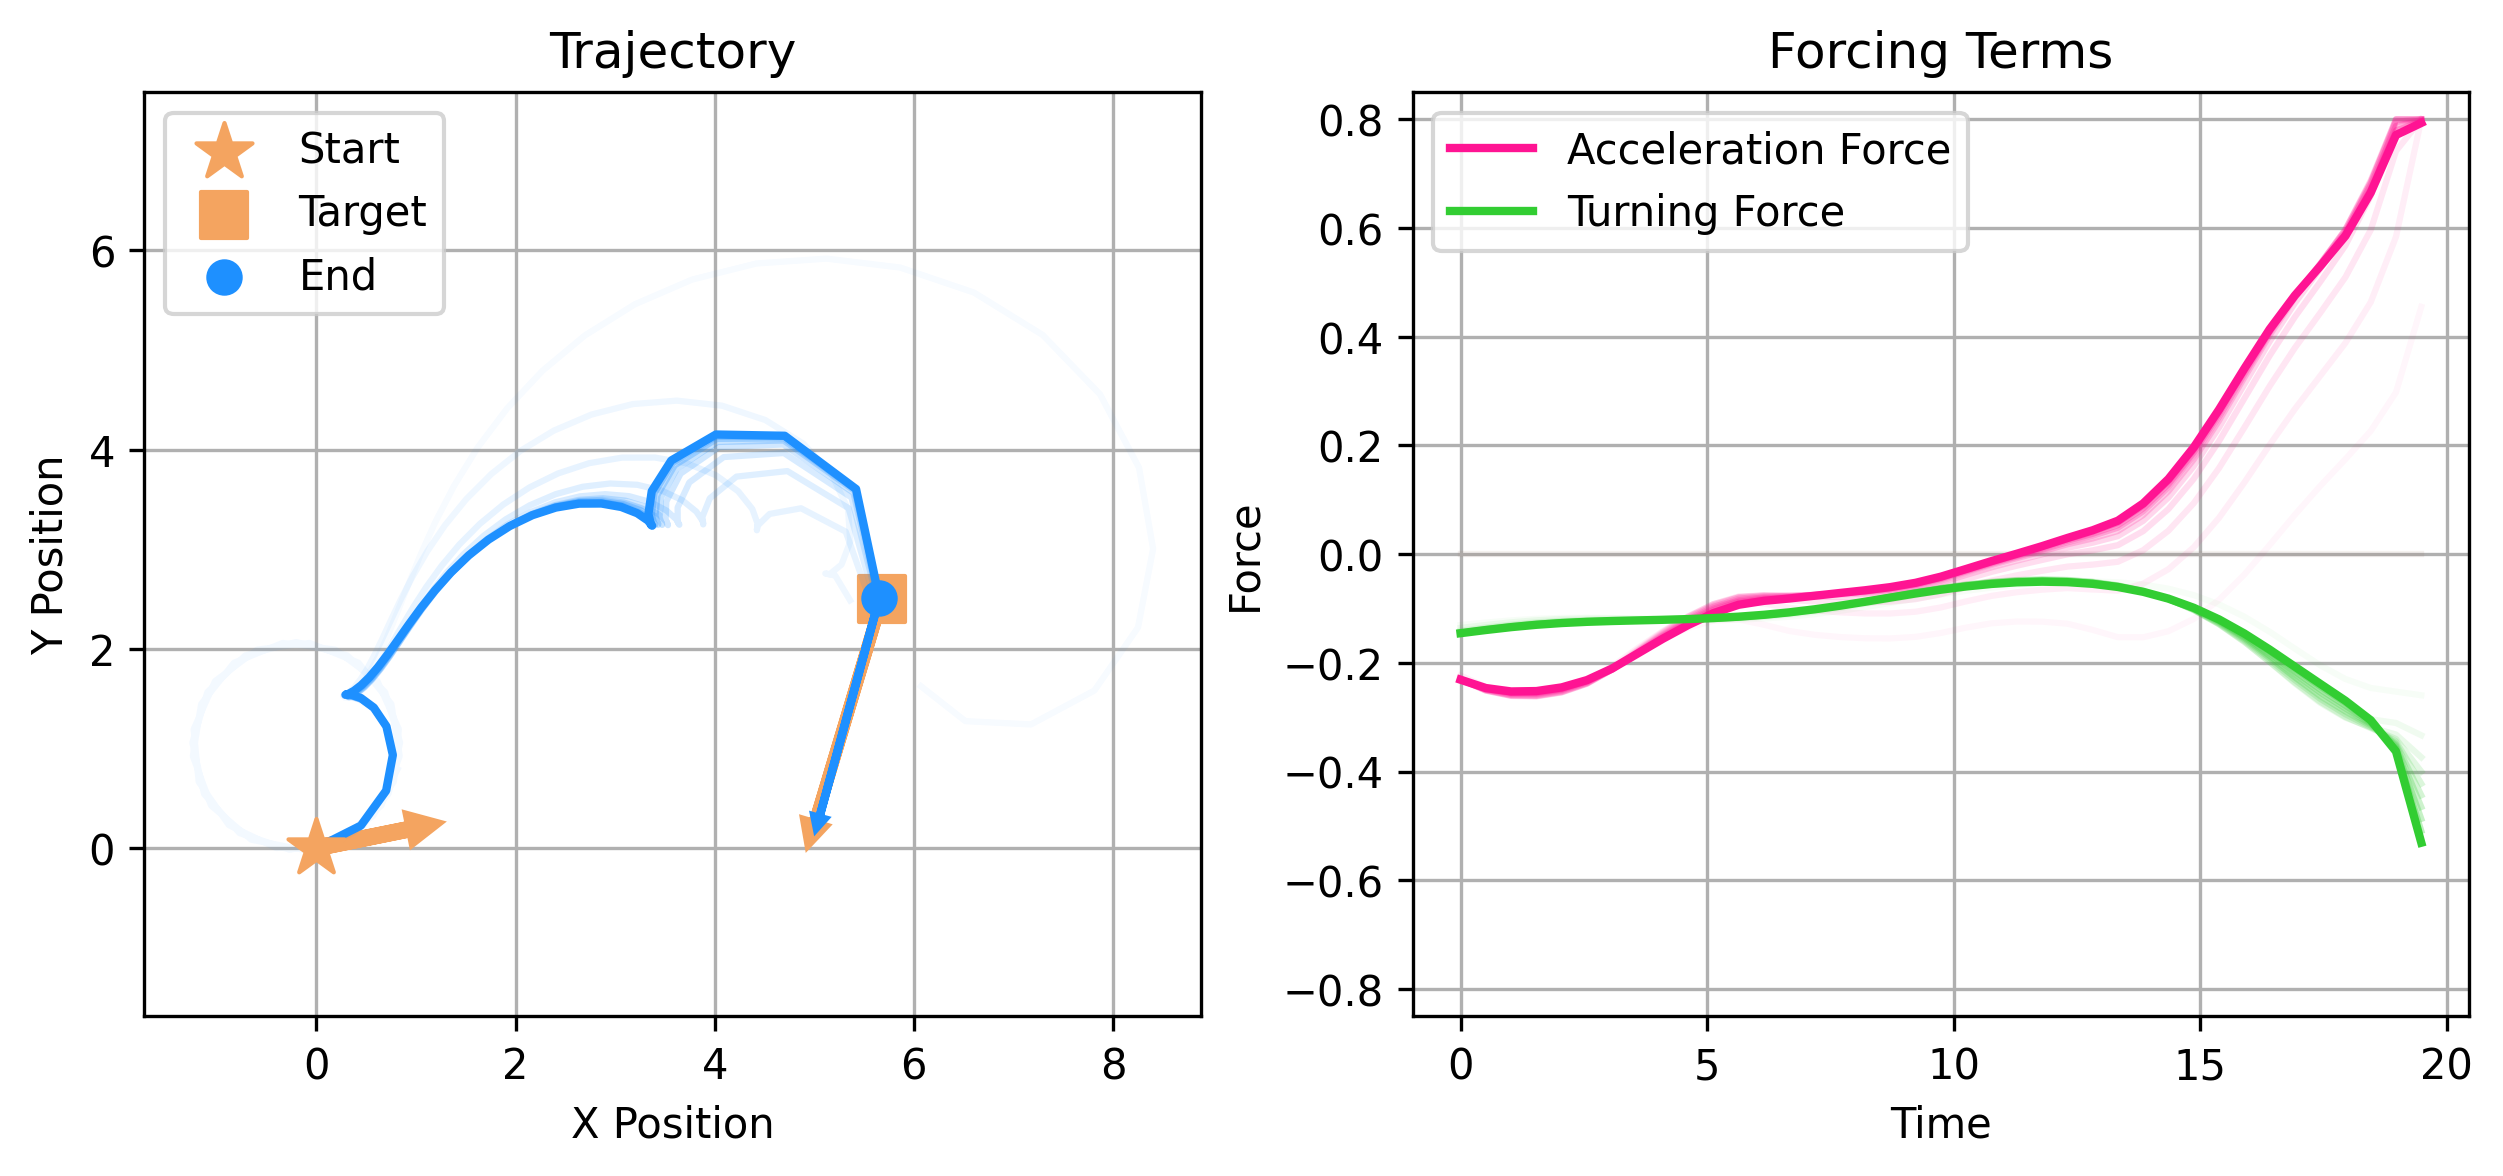

In [129]:
def solveForcingWithGrad(F_mat=None, t0=0, t1=5.5,  dt_max=0.25, lr=6e-2, weight_decay=1e-1, nsteps=1000, break_thresh=1e-5):
    v0 = pt.tensor([0, 0, 0.2, 1, 1], device=device)
    target = pt.tensor([5.68071168, 2.5029068, -1.8625, 2.375, -1.75], device=device)
    n_ts = int((t1 - t0) / dt_max)
    ts = pt.linspace(t0, t1, n_ts, device=device)



    if F_mat is None:
        F_mat = pt.nn.Parameter(0*pt.randn((n_ts-1, 2), device=device).clamp(-0.8,0.8))
    else:
        F_mat = pt.nn.Parameter(pt.tensor(F_mat, device=device))

    V_mat, _, loss = compute_path_gradient(v0, F_mat.detach(), ts, target)
    optim = pt.optim.AdamW([F_mat], lr=lr, weight_decay=weight_decay)

    figaxs = None
    figaxs = showTraj(V_mat.cpu(), F_mat.cpu(), ts.cpu(), target.cpu(), figaxs=figaxs, show=False, alpha=0.05)

    for i in range(nsteps):
        optim.zero_grad()
        with pt.no_grad():
            V_mat, grad, loss = compute_path_gradient(v0, F_mat, ts, target)
        F_mat.grad = grad

        if loss**0.5 < break_thresh:
            print(f'Exited early at Itteration {i+1}')
            break

        optim.step()
        with pt.no_grad():
            F_mat.clamp_(min=-0.8, max=0.8)

        if i % 50 == 49:
            print(f"Iteration {i+1}, Loss: {loss ** 0.5}")
            if i < nsteps-1:
                figaxs = showTraj(V_mat.cpu(), F_mat.cpu(), ts.cpu(), target.cpu(), figaxs=figaxs, show=False, alpha=0.35*max(0.1, i/nsteps))

    showTraj(V_mat.cpu(), F_mat.cpu(), ts.cpu(), target.cpu(), figaxs=figaxs, show=True, alpha=1.0)

    return F_mat.cpu(), ts.cpu()

F_mat, ts = solveForcingWithGrad(t0=0, t1=20, dt_max=0.5, nsteps=500, weight_decay=1e-1, lr=1e-2, break_thresh=0.03)


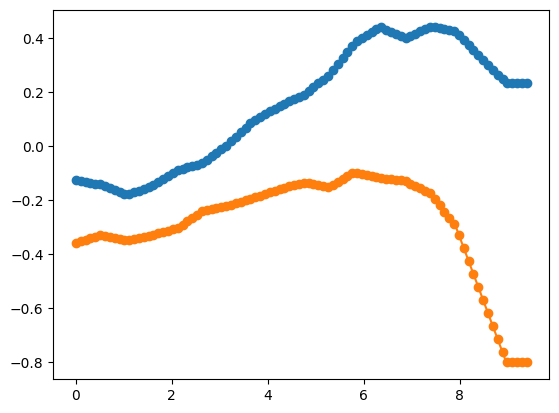

In [114]:
from scipy.interpolate import interp1d

def upscaleForcingTerms(F_mat, ts, dt_max):
    fs = F_mat.detach().numpy()
    fs = np.concatenate([fs[:,:], fs[-1,:][np.newaxis,:]], axis=0)
    t0 = ts[0]
    t1 = ts[-1]
    n_ts = int((t1 - t0) / dt_max)
    new_ts = np.linspace(t0, t1, n_ts)

    upscaled = interp1d(ts.numpy(), fs, axis=0)(new_ts[:-1])
    return upscaled, new_ts

upscaled, new_ts = upscaleForcingTerms(F_mat, ts, 0.1)


plt.plot(ts[:-1], F_mat.detach().numpy()[:,0])
plt.plot(ts[:-1], F_mat.detach().numpy()[:,1])
plt.scatter(new_ts[:-1], upscaled[:,0])
plt.scatter(new_ts[:-1], upscaled[:,1])
plt.show()


Iteration 50, Loss: 0.054710764437913895
Iteration 100, Loss: 0.02839142642915249
Iteration 150, Loss: 0.01806013658642769
Iteration 200, Loss: 0.01303513627499342
Iteration 250, Loss: 0.010945933870971203
Iteration 300, Loss: 0.010090894997119904
Iteration 350, Loss: 0.009769143536686897
Iteration 400, Loss: 0.009299193508923054
Iteration 450, Loss: 0.008690835908055305
Iteration 500, Loss: 0.008192104287445545
Iteration 550, Loss: 0.007750540506094694
Iteration 600, Loss: 0.0073524704203009605
Iteration 650, Loss: 0.006991617381572723
Iteration 700, Loss: 0.006658800877630711
Iteration 750, Loss: 0.006339475978165865
Iteration 800, Loss: 0.006056272424757481
Iteration 850, Loss: 0.005781372077763081
Iteration 900, Loss: 0.005652051419019699
Iteration 950, Loss: 0.1034860908985138
Iteration 1000, Loss: 0.008091378025710583


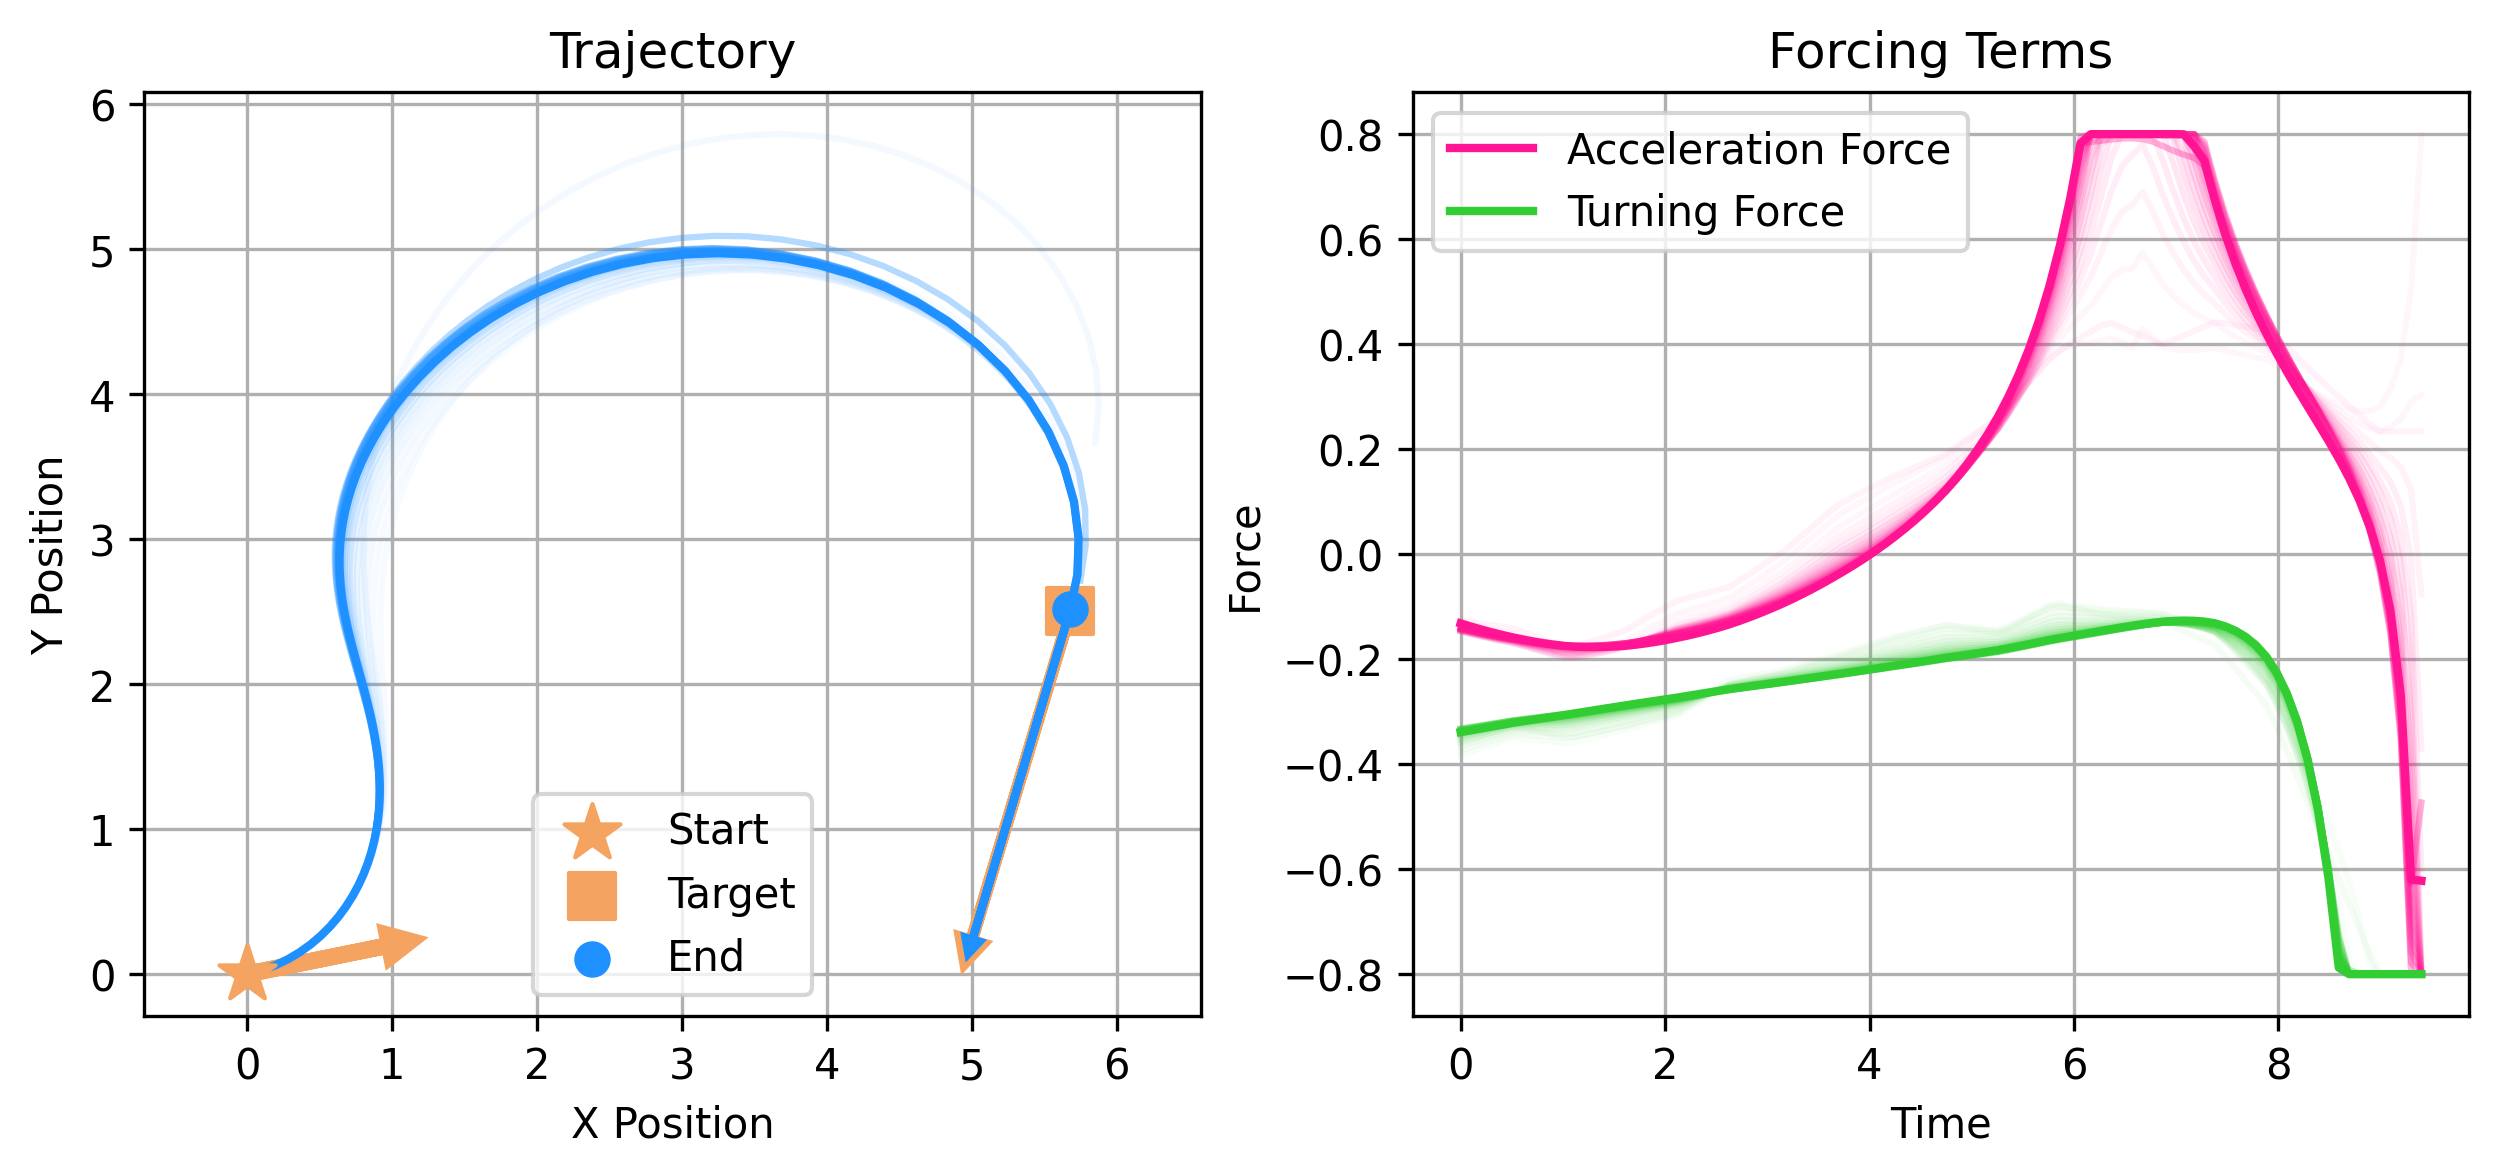

In [115]:
F_mat, ts = solveForcingWithGrad(F_mat=upscaled, t0=0, t1=9.5, dt_max=0.1, lr=3e-2, weight_decay=1e-1)
